In [1]:
## Neural Networks
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU, BatchNormalization, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

## GPU
# from numba import cuda
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib

## Standard libs
import numpy as np
from PIL import Image
import math
import os 

## Others
from sklearn import metrics
import pandas as pd
from multiprocessing.pool import ThreadPool
from keras.utils import OrderedEnqueuer
from keras.utils import Sequence

Using TensorFlow backend.
c:\users\mostafaosama2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\mostafaosama2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\mostafaosama2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dt

In [2]:
gpu_options = tf.GPUOptions(allow_growth=True)
custom_config=tf.ConfigProto(log_device_placement=True, allow_soft_placement=True, gpu_options=gpu_options)
custom_config.gpu_options.allocator_type = 'BFC'
custom_config.gpu_options.per_process_gpu_memory_fraction = 0.90
session = tf.InteractiveSession(config=custom_config)

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16431265192541625503, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7730941132
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10364526184303494431
 physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [72]:
## Images loading 

# trainData = "C:/Users/mostafaosama2/Desktop/Kaggle-Data/train"
trainData = "../../Data/regrData/train"
testData = "../../Data/regrData/test"

new_train = []

#  create a data generator
generator = ImageDataGenerator(rescale=1./255)

# X is the input images, Y1 is the same image (AE) , Y2 is the labels
def generate_data_generator(directory):
    genX = generator.flow_from_directory(directory, target_size=(96, 96), class_mode='input', color_mode='rgb', seed=7)
    genY = generator.flow_from_directory(directory, target_size=(96, 96), class_mode='binary', color_mode='rgb', seed=7)
    while True:
        Xi = next(genX)
        Yi1 = next(genY)
        yield Xi[0], [Xi[1], Yi1[1]]
            

In [73]:
n_epochs = 5
batch_size = 32
n_clusters = 4
optimizer = 'adam'
loss = 'mean_squared_error'

input_img = Input(shape=(96, 96, 3))  # adapt this if using `channels_first` image data format

encoder = Conv2D(filters=16, kernel_size=(3,3),strides=1, padding='same')(input_img)#x^2*16
encoder = LeakyReLU()(encoder)
encoder = Conv2D(filters=32, kernel_size=(3,3),strides=1, padding='same')(encoder)#x^2*32
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization()(encoder)
encoder = Conv2D(filters=64, kernel_size=(3,3),strides=2, padding='same')(encoder)#(x/2)^2*64
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization()(encoder)
encoder = MaxPooling2D()(encoder)#(x/4)^2*64
encoder = Conv2D(filters=128, kernel_size=(3,3),strides=2, padding='same')(encoder)#(x/8)^2*128
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization()(encoder)
encoder = MaxPooling2D()(encoder)#(x/16)^2*64
encoder = Conv2D(filters=64, kernel_size=(3,3),strides=1, padding='same')(encoder)#(x/16)^2*64
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization()(encoder)
encoder = Conv2D(filters=32, kernel_size=(3,3),strides=1, padding='same')(encoder)#(x/16)^2*32
encoder = LeakyReLU()(encoder)


bottleneck = Conv2D(filters=32, kernel_size=(1,1),strides=1, padding='same')(encoder)#(x/16)^2*16
bottleneck = LeakyReLU()(bottleneck)


decoder = Conv2D(filters=32, kernel_size=(1,1),strides=1, padding='same')(bottleneck)#(x/16)^2*32
decoder = LeakyReLU()(decoder)
decoder = Conv2D(filters=64, kernel_size=(3,3),strides=1, padding='same')(decoder)#(x/16)^2*64
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization()(decoder)
decoder = UpSampling2D()(decoder)#(x/8)^2*64
decoder = Conv2DTranspose(filters=128, kernel_size=(3,3),strides=2, padding='same')(decoder)#(x/4)^2*128
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization()(decoder)
decoder = UpSampling2D()(decoder)#(x/2)^2*128
decoder = Conv2DTranspose(filters=64, kernel_size=(3,3),strides=2, padding='same')(decoder)#x^2*64
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization()(decoder)
decoder = Conv2D(filters=32, kernel_size=(3,3),strides=1, padding='same')(decoder)#x^2*32
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization()(decoder)
decoder = Conv2D(filters=16, kernel_size=(3,3),strides=1, padding='same')(decoder)#x^2*16
decoder = LeakyReLU()(decoder)
decoder = Conv2D(filters=3, kernel_size=(3,3),strides=1, padding='same')(decoder)#x^2*3
decoded = LeakyReLU()(decoder)

regressor = Flatten()(bottleneck)
regressor = Dense(128)(regressor) 
regressor = LeakyReLU()(regressor)
regressor = Dense(64)(regressor) 
regressor = LeakyReLU()(regressor)
regressor = Dense(32)(regressor) 
regressor = LeakyReLU()(regressor)
regressor = Dense(1, activation='sigmoid')(regressor) 

autoencoder = Model(input_img, [decoded, regressor])
autoencoder.compile(optimizer=optimizer , loss=loss)
filepath = "../notebooks/checkpoint_epochs{}_batch{}_{}.h5".format(n_epochs,batch_size,optimizer)
# filepath = "C:/Users/mostafaosama2/Desktop/Generalised-WSI-Clustering/notebooks/checkpoint_epochs{}_batch{}_{}.h5".format(n_epochs,batch_size,optimizer)
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
ES = EarlyStopping(monitor='loss', min_delta=0, patience=30, mode='min', verbose=0, restore_best_weights=True)
callbacks_list = [checkpoint, ES]

# autoencoder.summary()

In [74]:
len(os.listdir(trainData))

1286

In [75]:
# with tf.device('/GPU:0'):
autoencoder_train = autoencoder.fit_generator(generator=generate_data_generator(trainData),
                    validation_data=generate_data_generator(testData),
                    steps_per_epoch=math.ceil(len(os.listdir(trainData)) / batch_size),
                    validation_steps=math.ceil(len(os.listdir(testData)) / batch_size),
                    epochs=n_epochs)

Found 293 images belonging to 2 classes.
Found 293 images belonging to 2 classes.
Found 1282 images belonging to 2 classes.
Epoch 1/5
Found 1282 images belonging to 2 classes.
 5/41 [==>...........................] - ETA: 1:54 - loss: 0.8607 - leaky_re_lu_48_loss: 0.5917 - dense_12_loss: 0.2690

KeyboardInterrupt: 

In [53]:
new_test = []

for filename in os.listdir(testData)[0:25]:
    if filename.endswith('.tif'):
        image = Image.open(os.path.join(testData, filename)) 
        new_test.append(np.asarray( image, dtype="uint8" ))
        
x_test = np.asarray(new_test)
x_test = x_test.astype('float32') / 255.

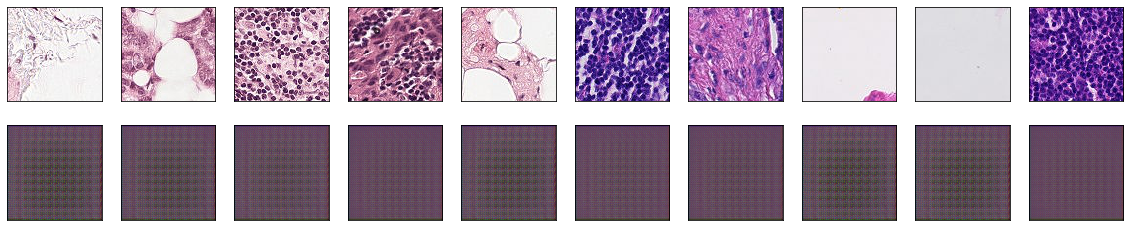

array([[[0.07930651, 0.04031822, 0.25904444],
        [0.23154816, 0.07863013, 0.34198785],
        [0.22402912, 0.02060218, 0.36587948],
        ...,
        [0.22796379, 0.06575229, 0.31682616],
        [0.260739  , 0.0641012 , 0.32810855],
        [0.16092467, 0.0734632 , 0.21898301]],

       [[0.06851642, 0.19110835, 0.36291954],
        [0.2920491 , 0.26295027, 0.4030404 ],
        [0.32319194, 0.20610012, 0.41331783],
        ...,
        [0.3431362 , 0.19791752, 0.38176385],
        [0.38208464, 0.225998  , 0.39570153],
        [0.24282384, 0.13634399, 0.24952911]],

       [[0.10294418, 0.20197928, 0.36922675],
        [0.29691195, 0.3110264 , 0.35124192],
        [0.37617233, 0.27990645, 0.38899088],
        ...,
        [0.4065527 , 0.25814024, 0.3615421 ],
        [0.42942896, 0.27571863, 0.32901415],
        [0.31881934, 0.18273573, 0.25349596]],

       ...,

       [[0.09185456, 0.2599356 , 0.34206793],
        [0.30421758, 0.34135526, 0.36917973],
        [0.36924127, 0

In [62]:
decoded_imgs = autoencoder.predict(x_test)[0]
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
len(decoded_imgs)
len(decoded_imgs[1])
decoded_imgs[1]